In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import numpy as np
import cachetools.func

In [2]:

def fix_region_name(df, pairs = [["Mainland China", "China"]]):
  # fix region names
    for p in pairs:
        df['Country/Region'] = df['Country/Region'].str.replace(p[0],p[1])
    return df

#-----
def merge_df_data(df1,df2):
    return pd.merge(df1, df2,how='left' ,on=['Province/State','Country/Region'])

#-----
def str_add_func(*args):      
    out = []
    for x in args:
        if isinstance(x,str):
            out.append(x)
    return '_'.join(out)


class covid_data():
    '''
      Python class to obtain global COVID19 data from 
      John Hopkins GIT repository. This data is updated daily, 
      and the most upto date information available on the web.  
    '''
    def __init__(self,**kwargs):
        nrow = kwargs.get('nrow',None)
        self.confirmed, self.dead, self.recovered = self.get_csseg_data(nrow=nrow)
    @staticmethod
    def create_ts(df):
        ts=df
        columns = ts['region']
        ts=ts.drop(['Province/State', 
                    'Country/Region',
                    'Lat', 
                    'Long',
                    'Population'], 
                   axis=1).set_index('region').T    

        ts.columns = columns 
        ts=ts.fillna(0)
        #
        ts.index.name = 'Date'
        return ts

    def search_agg(self, name,col='Country/Region',ts=True):
    
        if not isinstance(name,list):
            name = [name]

        out = {}
        for k,v in {'confirmed':self.confirmed,
                    'dead':self.dead,
                    'recovered':self.recovered}.items():

        #pd.columns(columns=)
            df_list= []     
            for n in name:
                df = v[v[col]==n].set_index(col).filter(regex='/20')
                df_list.append(df.sum(axis=0))

            df = pd.concat(df_list,axis=1, sort=False)
            df.columns = name
            out[k] = df

        # if ts:                
        #   out[k] = self.create_ts(df)
        # else:
        #   out[k] = df.T

        return out

    def search(self, name,col='Country/Region',ts=True):
        if not isinstance(name,list):
            name = [name]
        out = {}
        for k,v in {'confirmed':self.confirmed,
                    'dead':self.dead,
                    'recovered':self.recovered}.items():
            if ts:                
                out[k] = self.create_ts(v[v[col].map(lambda x: x in name)])
            else:
                out[k] = v[v[col] in name].T
        return out

    @cachetools.func.ttl_cache(maxsize=128, ttl=24 * 60)
    def get_csseg_data(self, nrow=None):
    
        url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master'
        path = f'{url}/csse_covid_19_data/csse_covid_19_time_series' 

        # 
    
        url = f'{path}/time_series_covid19_confirmed_global.csv'
        confirmed = fix_region_name(pd.read_csv(url, nrows=nrow, error_bad_lines=False))
        #
        url = f'{path}/time_series_covid19_deaths_global.csv'
        dead = fix_region_name(pd.read_csv(url, nrows=nrow, error_bad_lines=False))
        #
        url = f'{path}/time_series_covid19_recovered_global.csv'
    
        recovered = fix_region_name(pd.read_csv(url, nrows=nrow, error_bad_lines=False))
        print(confirmed.head())
        #
        return confirmed, dead, recovered


In [3]:
cd = covid_data()
cd.confirmed.head()
countries = ['Senegal']
mm = cd.search_agg(countries)

  Province/State Country/Region       Lat  ...  8/5/20  8/6/20  8/7/20
0            NaN    Afghanistan  33.93911  ...   36829   36896   37015
1            NaN        Albania  41.15330  ...    5889    6016    6151
2            NaN        Algeria  28.03390  ...   33055   33626   34155
3            NaN        Andorra  42.50630  ...     939     944     955
4            NaN         Angola -11.20270  ...    1395    1483    1538

[5 rows x 203 columns]


In [4]:
for ix, ctype in enumerate(['confirmed', 'dead', 'recovered']):
    df = mm[ctype].stack().reset_index()
    #print(df.head())
    df = df.rename(columns={'level_0':'date','level_1':'country',0:ctype})     
    if ix==0:
        df['date'] = pd.to_datetime(df['date'])
        dfall = df
    else:
        dfall[ctype] = df[ctype]

In [5]:
dfall.drop(['country'],axis=1,inplace=True)
dfall['currentCase'] = dfall['confirmed'] - dfall['recovered'] - dfall['dead']
dfall.columns=['ObservationDate', 'Confirmed', 'Deaths', 'Recovered','currentCase']

In [6]:
dfall.head()

,ObservationDate,Confirmed,Deaths,Recovered,currentCase
0,2020-01-22,0,0,0,0
1,2020-01-23,0,0,0,0
2,2020-01-24,0,0,0,0
3,2020-01-25,0,0,0,0
4,2020-01-26,0,0,0,0


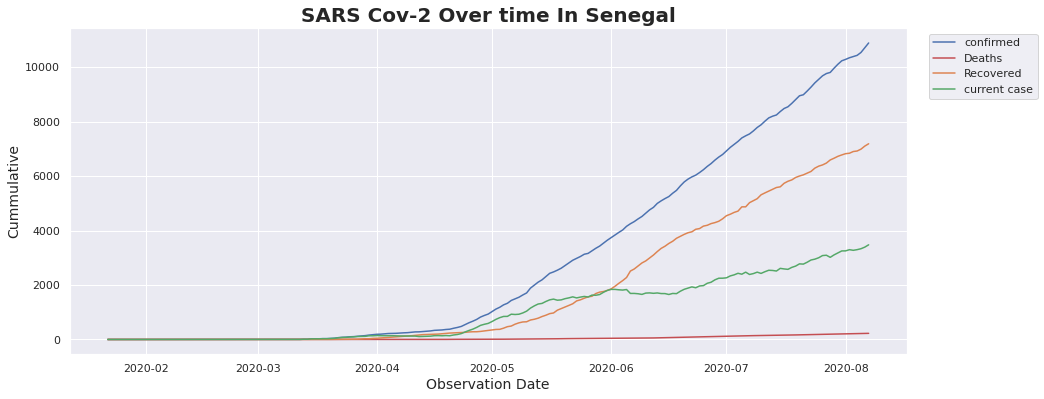

In [18]:
import seaborn as sns
import datetime
sns.set()
months = ['February', 'March', 'April', 'May', 'June', 'July', 'August']
plt.figure(figsize=(15, 6))
sns.lineplot(x='ObservationDate', y='Confirmed', data=dfall)
sns.lineplot(x='ObservationDate', y='Deaths', data=dfall, color='r')
sns.lineplot(x='ObservationDate', y='Recovered', data=dfall)
sns.lineplot(x='ObservationDate', y='currentCase', data=dfall)
plt.title('SARS Cov-2 Over time In Senegal', size=20, fontweight='bold')
plt.legend(['confirmed', 'Deaths', 'Recovered', 'current case'], loc='best', bbox_to_anchor=(1.02, 1))
plt.ylabel('Cummulative', fontsize=14)
plt.xlabel('Observation Date', fontsize=14)
# plt.xticks(range(months))
plt.show()

This shows that Senegal is doing okay in curtailing the spread of $COVID-19$ has the Number of current cases is less than the Recovered and there are no much deaths recorded

In [19]:
def determinate_beta_gamma_delta(data=None):
    '''
        this function compute transmission rate, recovered rate and fatalities rate over time
        params: data
        return: beta, gamma, delta
    '''
    
    beta = []
    gamma = []
    delta = []
    
    for t in range(len(data.ObservationDate.values)):
        
        x = data.Confirmed.iloc[t]
        y = data.Deaths.iloc[t]
        z = data.Recovered.iloc[t]
        w = data.currentCase.iloc[t]
        
        if x == 0.0:
            beta.append(0)
            gamma.append(0)
            delta.append(0)
        else:
            beta_t = w/x
            gamma_t = z/x
            delta_t = y/x
            
            beta.append(beta_t)
            gamma.append(gamma_t)
            delta.append(delta_t)
            
    return np.array(beta), np.array(gamma), np.array(delta)        

In [20]:
transmission, recovery, fatality = determinate_beta_gamma_delta(data=dfall)

In [21]:
parameter_dynamic = pd.DataFrame()
parameter_dynamic['beta'] = transmission
parameter_dynamic['gamma'] = recovery
parameter_dynamic['delta'] = fatality
parameter_dynamic.index = dfall.ObservationDate

In [22]:
def find_R0(data=None):
    '''
        This function compute R0 over time
        params: data
        return: R0
    '''
    return data.beta.values/(data.gamma.values + data.delta.values)

In [23]:
#Compute R0
parameter_dynamic['R0'] = find_R0(data=parameter_dynamic)
print(parameter_dynamic['R0'].min())
parameter_dynamic.columns=['\u03B2', '\u03B3', '\u03B4','R0']
parameter_dynamic.columns

0.4313955436421511


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Index(['β', 'γ', 'δ', 'R0'], dtype='object')

In [24]:
parameter_dynamic

,β,γ,δ,R0
ObservationDate,,,,
2020-01-22,0.000000,0.000000,0.000000,NaN
2020-01-23,0.000000,0.000000,0.000000,NaN
2020-01-24,0.000000,0.000000,0.000000,NaN
2020-01-25,0.000000,0.000000,0.000000,NaN
2020-01-26,0.000000,0.000000,0.000000,NaN
...,...,...,...,...
2020-08-03,0.315232,0.664452,0.020316,0.460349
2020-08-04,0.316143,0.663344,0.020514,0.462293
2020-08-05,0.316189,0.663124,0.020687,0.462392


(18283.0, 18481.0)


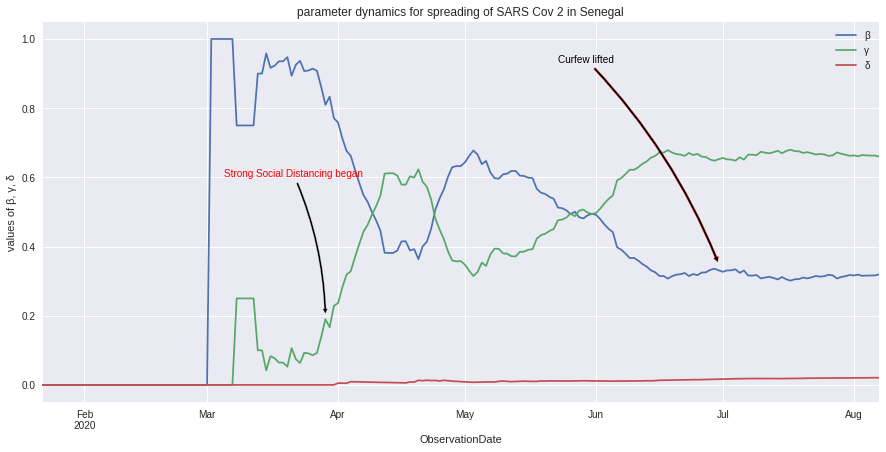

In [25]:
plt.style.use('seaborn')
ax=parameter_dynamic[['\u03B2', '\u03B3', '\u03B4']].plot(figsize=(15,7))
print (ax.get_xlim())
plt.ylabel('values of \u03B2, \u03B3, \u03B4')
plt.annotate(
        'Strong Social Distancing began',
        xy=(18350.0, 0.2),
        xycoords="data",
        xytext=(0.3, 0.6),
        textcoords="axes fraction",
        size=10,
        va="center",
        color='red',
        ha="center",
        arrowprops=dict(
            arrowstyle="simple", connectionstyle="arc3,rad=-0.1", fc="black"
        ),transform=ax.transAxes)

plt.annotate(
        'Curfew lifted',
        xy=(18443.0, 0.35),
        xycoords="data",
        xytext=(0.65, 0.9),
        textcoords="axes fraction",
        size=10,
        va="center",
        color='black',
        ha="center",
        arrowprops=dict(
            arrowstyle="simple", connectionstyle="arc3,rad=-0.1", fc="black",color='red'
        ),transform=ax.transAxes)
plt.title('parameter dynamics for spreading of SARS Cov 2 in Senegal')
plt.savefig('paramater dynamics.png',bbox_inches='tight')

From the chart it shows that after the Curfew was lifted the Recovery rate increases and the transmission rate (Spread Rate) decreases